# Imports

In [24]:
import pdfplumber
import pandas as pd
import matplotlib.pyplot as plt
import re
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

plt.style.use('default')

In [25]:
from fredapi import Fred

api_key = "902a2e4cf2100e3f1045cfbec0139940"
fred = Fred(api_key=api_key)

## Ingest Category Mapping

In [26]:
category_mapping_df = pd.read_csv('../a_Configs/department_mapping.csv')

## Ingest Maine Budget Data

In [27]:
budget_to_end_page = {
    "2026-2027": 8,
    "2024-2025": 9,
    "2022-2023": 8,
    "2020-2021": 8,
    "2018-2019": 8,
    "2016-2017": 8
}

In [28]:
def parse_headline_table(headline_table, first_year, second_year):
    """
    Parse the headline_table text into a DataFrame with columns:
    Department | Funding Source | first_year | second_year

    Args:
        headline_table (str): The text containing budget information

    Returns:
        pd.DataFrame: DataFrame with parsed budget data
    """
    lines = headline_table.strip().split('\n')
    data = []
    current_dept = None
    funding_pattern = re.compile(r'^(.+?)\s+(\(?\d{1,3}(?:,\d{3})*\)?)\s+(\(?\d{1,3}(?:,\d{3})*\)?)$')

    for line in lines:
        line = line.strip()
        if not line:
            continue

        if line[0].isdigit():
            # New department
            parts = line.split(' ', 1)
            if len(parts) > 1:
                current_dept = parts[1]
            else:
                current_dept = line
        else:
            match = funding_pattern.match(line)
            if match:
                # Funding source
                funding_source = match.group(1).strip()
                amt_first_year_str = match.group(2).replace(',', '')
                amt_second_year_str = match.group(3).replace(',', '')

                try:
                    amt_first_year = float(amt_first_year_str)
                except ValueError:
                    amt_first_year = 0.0

                try:
                    amt_second_year = float(amt_second_year_str)
                except ValueError:
                    amt_second_year = 0.0

                data.append({
                    'Department': current_dept,
                    'Funding Source': funding_source,
                    first_year: amt_first_year,
                    second_year: amt_second_year
                })

    df = pd.DataFrame(data)
    df = df.set_index(['Department', 'Funding Source'])
    
    return df

In [29]:
# Ingest all budgets and concatenate into a single DataFrame
me_as_reported_df = pd.DataFrame()

for budget in budget_to_end_page.keys():
    end_page = budget_to_end_page[budget]
    first_year, second_year = budget.split('-')
    with pdfplumber.open(f"../z_Data/ME/{budget} ME State Budget.pdf") as pdf:
        pages = pdf.pages[1:end_page]
        text_list = [page.extract_text() for page in pages]
        headline_table = '\n'.join(text_list)
    budget_df = parse_headline_table(headline_table, first_year, second_year)
    me_as_reported_df = pd.concat([me_as_reported_df, budget_df], axis=1)

me_as_reported_df = me_as_reported_df.sort_index(axis=1)

In [30]:
me_as_reported_df.xs('DEPARTMENT OF TECHNOLOGY SERVICES', level='Department')  # Example lookup

,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027
Funding Source,,,,,,,,,,,,
GENERAL FUND,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FEDERAL EXPENDITURES FUND,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OTHER SPECIAL REVENUE,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STATEWIDE RADIO & NETWORK FUND,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEPARTMENT TOTAL,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# Create standardized df for comparison with NH

me_mapping_df = category_mapping_df[category_mapping_df['State'] == 'Maine'][['As Reported', 'Standardized']]

me_standardized_df = me_as_reported_df.reset_index().merge(me_mapping_df, left_on='Department', right_on='As Reported', how='left')
me_standardized_df['Standardized'] = me_standardized_df['Standardized']#.fillna(me_standardized_df['Department'])
me_standardized_df['Standardized'] = me_standardized_df['Standardized'].str.upper()
me_standardized_df.drop(columns=['Department', 'As Reported'], inplace=True)
me_standardized_df.rename(columns={'Standardized': 'Department'}, inplace=True)
me_standardized_df = me_standardized_df.groupby(['Department', 'Funding Source']).sum()
# me_standardized_df = me_standardized_df.set_index(['Department', 'Funding Source'])

In [32]:
#me_standardized_df.xs('GRAND TOTALS - ALL DEPARTMENTS', level='Department').sort_values(by='2025', ascending=False).head()

In [33]:
department_total_df = me_as_reported_df.xs('GENERAL FUND', level='Funding Source').fillna(0)
department_total_df = department_total_df[department_total_df.index != 'GRAND TOTALS - ALL DEPARTMENTS']

In [34]:
department_total_df.sort_values(by='2025', ascending=False).head()

,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027
Department,,,,,,,,,,,,
DEPARTMENT OF HEALTH AND HUMAN SERVICES (Formerly DHS),8.116299e+08,8.082864e+08,1.168639e+09,1.247538e+09,1.326124e+09,1.266190e+09,1.265339e+09,1.638181e+09,1.750752e+09,2.077100e+09,2.183727e+09,2.164550e+09
DEPARTMENT OF EDUCATION,1.172391e+09,1.185229e+09,1.255456e+09,1.345719e+09,1.438616e+09,1.513040e+09,1.618803e+09,1.695441e+09,1.796801e+09,1.864988e+09,1.938654e+09,1.977930e+09
DEPARTMENT OF ADMINISTRATIVE AND FINANCIAL SERVICES,1.376243e+08,1.493829e+08,1.650539e+08,1.922312e+08,2.010628e+08,2.153061e+08,1.463696e+08,1.524649e+08,3.033649e+08,2.905584e+08,2.684863e+08,2.790483e+08
BOARD OF TRUSTEES OF THE UNIVERSITY OF MAINE SYSTEM,2.006770e+08,2.016380e+08,2.104711e+08,2.124881e+08,2.244670e+08,2.226500e+08,2.323788e+08,2.571796e+08,2.693140e+08,2.797700e+08,2.893515e+08,3.014966e+08
DEPARTMENT OF CORRECTIONS,1.778720e+08,1.785551e+08,1.855766e+08,1.861504e+08,1.944268e+08,1.302934e+08,2.067333e+08,2.097895e+08,2.304604e+08,2.367201e+08,2.578415e+08,2.591156e+08


## Ingest NH Budget Data

In [35]:
nh_as_reported_df = pd.DataFrame()

budget_years = [str(year) for year in range(2016, 2026)]

for year in budget_years:
    df = pd.read_csv(f"../z_Data/NH/{year} NH State Expenditure.csv")
    df_cleaned = df.dropna(axis=0, how='all').dropna(axis=1, how='all')
    df_cleaned.columns = [col.upper().replace("\n", "").replace("JUNE ", "").replace(r'FY\d{2}', "") for col in df_cleaned.columns]
    df_cleaned.columns = [re.sub("FY\d{2} ", "", col).lstrip() for col in df_cleaned.columns]
    df_appr = df_cleaned[['DEPARTMENT', 'APPROPRIATION']]
    df_appr = df_appr.rename(columns={'APPROPRIATION': year})
    df_appr[year] = df_appr[year].astype(str).str.replace(",", "").astype(float)
    df_appr['DEPARTMENT'] = df_appr['DEPARTMENT'].str.strip()

    df_appr.set_index('DEPARTMENT', inplace=True)
    nh_as_reported_df = pd.concat([nh_as_reported_df, df_appr], axis=1)

<>:9: SyntaxWarning:

invalid escape sequence '\d'

<>:9: SyntaxWarning:

invalid escape sequence '\d'

/var/folders/jd/b78nww_n7txgdhyclm8vq1180000gn/T/ipykernel_22647/87115543.py:9: SyntaxWarning:

invalid escape sequence '\d'



In [36]:
# Create standardized df for NH

nh_mapping_df = category_mapping_df[category_mapping_df['State'] == 'New Hampshire'][['As Reported', 'Standardized']]

nh_standardized_df = nh_as_reported_df.reset_index().merge(nh_mapping_df, left_on='DEPARTMENT', right_on='As Reported', how='left')
nh_standardized_df['Standardized'] = nh_standardized_df['Standardized'].str.upper()
nh_standardized_df.drop(columns=['DEPARTMENT', 'As Reported'], inplace=True)
nh_standardized_df.rename(columns={'Standardized': 'DEPARTMENT'}, inplace=True)
nh_standardized_df = nh_standardized_df.groupby('DEPARTMENT').sum()

In [37]:
nh_standardized_df.head()

,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
DEPARTMENT,,,,,,,,,,
ADMINISTRATION & FINANCE,127730602.0,151119266.0,159431614.0,139674078.0,143259269.0,129600713.0,160843503.0,249304450.0,254087760.0,232674051.0
AGRICULTURE & CONSERVATION,279256049.0,167572912.0,228419721.0,244848711.0,321991165.0,280184515.0,508730343.0,384907726.0,489104643.0,412960668.0
ATTORNEY GENERAL,96539215.0,42714487.0,40375583.0,40983942.0,50898654.0,49905343.0,65767064.0,192669456.0,236173389.0,153186333.0
COMMUNITY COLLEGES,0.0,43778775.0,46475000.0,47075000.0,57255000.0,55360000.0,57500000.0,63500000.0,69830000.0,68542851.0
CORRECTIONS,0.0,113870177.0,120484090.0,130814573.0,138586353.0,139084131.0,156013362.0,183965049.0,194716271.0,197373739.0


In [38]:
nh_mapping_df[nh_mapping_df['As Reported'] == 'TRANSPORTATION']

,As Reported,Standardized
112,TRANSPORTATION,Transportation


In [39]:
nh_standardized_df.sort_values(by='2025', ascending=False).head(10)

,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
DEPARTMENT,,,,,,,,,,
HEALTH & HUMAN SERVICES,2.705395e+09,3.061726e+09,2.960404e+09,2.995991e+09,3.276286e+09,4.136201e+09,4.420079e+09,4.420877e+09,4.600524e+09,4.809140e+09
EDUCATION,1.244818e+09,1.283613e+09,1.317492e+09,1.355369e+09,1.449941e+09,1.953677e+09,2.104823e+09,2.055884e+09,2.025101e+09,1.759922e+09
TRANSPORTATION,1.520177e+09,1.541065e+09,1.433324e+09,1.407295e+09,1.382176e+09,1.399799e+09,1.446914e+09,1.715776e+09,1.641726e+09,1.619087e+09
AGRICULTURE & CONSERVATION,2.792560e+08,1.675729e+08,2.284197e+08,2.448487e+08,3.219912e+08,2.801845e+08,5.087303e+08,3.849077e+08,4.891046e+08,4.129607e+08
POLICING,2.085139e+08,2.111859e+08,2.414273e+08,2.295179e+08,2.244728e+08,3.304987e+08,3.372759e+08,4.698367e+08,4.814869e+08,3.644418e+08
TREASURY,2.039418e+08,1.989782e+08,2.027828e+08,2.029611e+08,2.566642e+08,2.472603e+08,2.722911e+08,3.071551e+08,2.872914e+08,2.734485e+08
ADMINISTRATION & FINANCE,1.277306e+08,1.511193e+08,1.594316e+08,1.396741e+08,1.432593e+08,1.296007e+08,1.608435e+08,2.493044e+08,2.540878e+08,2.326741e+08
CORRECTIONS,0.000000e+00,1.138702e+08,1.204841e+08,1.308146e+08,1.385864e+08,1.390841e+08,1.560134e+08,1.839650e+08,1.947163e+08,1.973737e+08
ECONOMIC DEVELOPMENT,0.000000e+00,0.000000e+00,4.198000e+07,3.967425e+07,2.800789e+07,2.766386e+07,1.577735e+08,2.816203e+08,1.886149e+08,1.618568e+08


In [40]:
nh_as_reported_df.sort_values(by='2025', ascending=False).head(10)

,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
DEPARTMENT,,,,,,,,,,
STATE TOTALS,7.298789e+09,7.609597e+09,7.573334e+09,7.649197e+09,9.851111e+09,1.070392e+10,1.116340e+10,1.184435e+10,1.178858e+10,1.132454e+10
HHS: COMMISSIONER'S OFFICE,NaN,3.061307e+09,2.959969e+09,2.995259e+09,3.275300e+09,4.135133e+09,4.419217e+09,4.419964e+09,4.600629e+09,4.808592e+09
EDUCATION DEPT OF,1.244818e+09,1.283613e+09,1.317492e+09,1.355369e+09,1.449941e+09,1.953677e+09,2.104823e+09,2.055884e+09,2.025101e+09,1.759922e+09
TRANSPORTATION,NaN,1.541065e+09,1.433324e+09,1.407295e+09,1.382176e+09,1.399799e+09,1.446914e+09,1.715776e+09,1.641726e+09,1.619087e+09
ENVIRONMENTAL SERV,NaN,1.601342e+08,2.228025e+08,2.389943e+08,3.155704e+08,2.649165e+08,4.990219e+08,3.730181e+08,4.649689e+08,3.950457e+08
SAFETY,NaN,2.078791e+08,2.380131e+08,2.261781e+08,2.215786e+08,3.276996e+08,3.322634e+08,4.628774e+08,4.712151e+08,3.568663e+08
TREASURY,NaN,1.989782e+08,2.027828e+08,2.029611e+08,2.566642e+08,2.472603e+08,2.722911e+08,3.071551e+08,2.872914e+08,2.734485e+08
ADMINISTRATIVE SERV,NaN,1.511193e+08,1.594316e+08,1.396741e+08,1.432593e+08,1.296007e+08,1.608435e+08,2.493044e+08,2.540878e+08,2.326741e+08
CORRECTIONS,NaN,1.138702e+08,1.204841e+08,1.308146e+08,1.385864e+08,1.390841e+08,1.560134e+08,1.839650e+08,1.947163e+08,1.973737e+08


In [41]:
def create_comparison_df(year):
    me_totals = me_standardized_df.xs('DEPARTMENT TOTAL', level='Funding Source')[year]
    nh_totals = nh_standardized_df[year]
    comparison_df = pd.DataFrame({
        'ME': me_totals,
        'NH': nh_totals
    }).fillna(0)
    return comparison_df


In [42]:
# Create scatter plot comparing ME and NH budgets for a given year

year = '2025'
departments_to_ignore = []#["HEALTH & HUMAN SERVICES", "EDUCATION"]

comparison_df = (create_comparison_df(year) / 1e6).round(0)
comparison_df = comparison_df.drop(departments_to_ignore)
comparison2_df = (create_comparison_df('2018') / 1e6).round(0)
comparison2_df = comparison2_df.drop(departments_to_ignore)

fig = go.Figure()

# First trace
fig.add_trace(go.Scatter(x=comparison_df['ME'], y=comparison_df['NH'],
                        mode='markers', name=f'{year}',
                        text=comparison_df.index))

# Second trace  
fig.add_trace(go.Scatter(x=comparison2_df['ME'], y=comparison2_df['NH'],
                        mode='markers', name='2018',
                        hovertext=comparison2_df.index,
                        marker=dict(opacity=0, color='gray')))

# add connecting lines
for dept in comparison_df.index:
    if dept in comparison2_df.index:
        fig.add_trace(go.Scatter(
            x=[comparison_df.loc[dept, 'ME'], comparison2_df.loc[dept, 'ME']],
            y=[comparison_df.loc[dept, 'NH'], comparison2_df.loc[dept, 'NH']],
            mode='lines',
            name=f'{dept} connection',
            showlegend=False,
            line=dict(color='gray', dash='dot')
        ))

# Add y=x line
x_range = np.linspace(comparison_df['ME'].min(), comparison_df['ME'].max(), 100)
fig.add_trace(go.Scatter(x=x_range, y=x_range, mode='lines', 
                        name='y=x', line=dict(color='gray', dash='dash')))

fig.update_layout(width=600,
    height=600,
    title=f'Maine vs New Hampshire State Budgets',
                  xaxis_title='Maine Budget (Million $)', 
                  yaxis_title='New Hampshire Budget (Million $)')

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.show()

## Ingest FRED Data

In [43]:
def get_indexed_fred_series(series_id, start_date, base_multiplier, freq='YE'):
    """
    Fetch FRED series data, downsample to specified frequency, filter by date,
    index relative to first value, convert index to year strings, and re-index with multiplier.
    
    Parameters:
    - fred: Initialized Fred API object
    - series_id: FRED series identifier (e.g., 'CPIAUCSL')
    - start_date: Start date for filtering (default '2016')
    - base_multiplier: Multiplier for re-indexing (default 8.2)
    - freq: Resampling frequency (default 'YE' for yearly, use 'M' for monthly)
    
    Returns:
    - pandas.Series: Processed and re-indexed series
    """
    data = fred.get_series(series_id)
    resampled = data.resample(freq).mean()
    filtered = resampled[resampled.index >= start_date]
    indexed = filtered / filtered.iloc[0]
    indexed.index = indexed.index.year.astype(str)
    reindexed = indexed * base_multiplier
    return reindexed

# Plotting

## Plotting Functions

In [44]:
def produce_funding_chart(ax, funding_source, input_df = me_as_reported_df, name=''):
    
    # Prepare dataframes

    fund_df = input_df.xs(funding_source, level='Funding Source').fillna(0)
    df = fund_df[fund_df.index != 'GRAND TOTALS - ALL DEPARTMENTS']
    df = df.sort_values(by='2027', ascending=False) / 1e9

    start_year = '2016'
    total_funding_name = 'GRAND TOTALS - ALL DEPARTMENTS' if funding_source == 'DEPARTMENT TOTAL' else funding_source
    grand_total_start = input_df.loc[('GRAND TOTALS - ALL DEPARTMENTS', total_funding_name), start_year] / 1e9
    start_value = grand_total_start if grand_total_start > 0 else 8.2
    cpi_yearly_reindexed = get_indexed_fred_series('CPIAUCSL', start_year, start_value)
    maine_gdp_reindexed = get_indexed_fred_series('MENQGSP', start_year, start_value)
    hh_income_reindexed = get_indexed_fred_series('MEHOINUSMEA646N', start_year, start_value)
    population = get_indexed_fred_series('MEPOP', start_year, start_value)#1.332e6)

    # Plotting
    top_5 = df.iloc[:5].index
    ax.stackplot(df.columns, df.values, labels=top_5)

    ax.plot(cpi_yearly_reindexed.index, cpi_yearly_reindexed.values, color='black', linestyle='--', label='CPI (Re-Indexed)')
    ax.plot(maine_gdp_reindexed.index, maine_gdp_reindexed.values, color='Blue', linestyle='--', label='Maine GDP (Re-Indexed)')
    ax.plot(population.index, population.values, color='RED', linestyle='--', label='Maine Res. Population')

    # Chart features
    ax.grid(axis='y', alpha=0.5, linestyle='dotted')
    ax.legend(loc='upper left', fontsize='8')

    if(name != ''):
        budget_name = name
    elif(funding_source == "DEPARTMENT TOTAL"):
        budget_name = 'State Budget'
    else:
        budget_name = funding_source

    ax.set_title(f'Maine {budget_name} by Department (in Billions)')
    ax.set_xlabel('Fiscal Year')
    ax.set_ylabel('Budget (Billions of $)')

    return df

In [ ]:
def produce_department_chart(ax, department):
    
    department_df = me_as_reported_df.xs(department, level='Department').fillna(0)
    df = department_df[department_df.index != 'DEPARTMENT TOTAL']
    df = df.sort_values(by='2027', ascending=False) / 1e6

    start_year = '2016'
    total_funding_name = 'GRAND TOTALS - ALL DEPARTMENTS' if funding_source == 'DEPARTMENT TOTAL' else funding_source
    grand_total_start = me_as_reported_df.loc[('GRAND TOTALS - ALL DEPARTMENTS', total_funding_name), start_year] / 1e9
    start_value = grand_total_start if grand_total_start > 0 else 8.2
    cpi_yearly_reindexed = get_indexed_fred_series('CPIAUCSL', start_year, start_value)
    maine_gdp_reindexed = get_indexed_fred_series('MENQGSP', start_year, start_value)
    hh_income_reindexed = get_indexed_fred_series('MEHOINUSMEA646N', start_year, start_value)
    population = get_indexed_fred_series('MEPOP', start_year, start_value))

    # Plotting
    top_5 = df.iloc[:5].index
    ax.stackplot(df.columns, df.values, labels=top_5)

    ax.plot(cpi_yearly_reindexed.index, cpi_yearly_reindexed.values, color='black', linestyle='--', label='CPI (Re-Indexed)')
    ax.plot(maine_gdp_reindexed.index, maine_gdp_reindexed.values, color='Blue', linestyle='--', label='Maine GDP (Re-Indexed)')
    ax.plot(population.index, population.values, color='RED', linestyle='--', label='Maine Res. Population')

    # Chart features
    ax.grid(axis='y', alpha=0.5, linestyle='dotted')
    ax.legend(loc='upper left', fontsize='8')

    ax.set_title(f'{department} Spending by Funding Source (in Millions)')
    ax.set_xlabel('Fiscal Year')
    ax.set_ylabel('Budget (Millions of $)')

    return df

## Investigations

In [51]:
# funding_sources = ['DEPARTMENT TOTAL'] + me_as_reported_df.xs('GRAND TOTALS - ALL DEPARTMENTS', level='Department').index.unique().tolist()
# number_of_sources = len(funding_sources)

# fig, ax = plt.subplots(number_of_sources, 1, figsize=(10, 6 * number_of_sources))

# for i, source in enumerate(funding_sources):
#     produce_funding_chart(ax[i], source)   

# fig.show()

NameError: name 'funding_source' is not defined

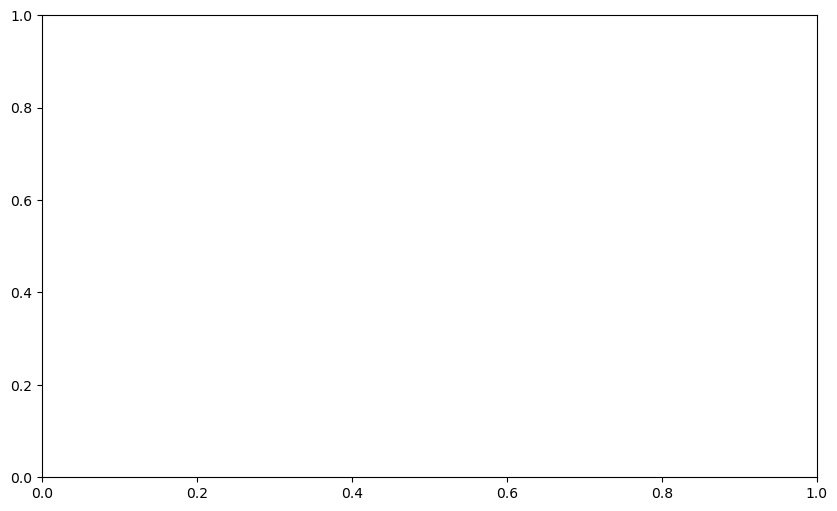

In [52]:
# Chart Department by Funding Source

fig, ax = plt.subplots(figsize=(10,6))

produce_department_chart(ax, 'DEPARTMENT OF TRANSPORTATION')

fig.show()

/var/folders/jd/b78nww_n7txgdhyclm8vq1180000gn/T/ipykernel_22647/1064727396.py:11: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



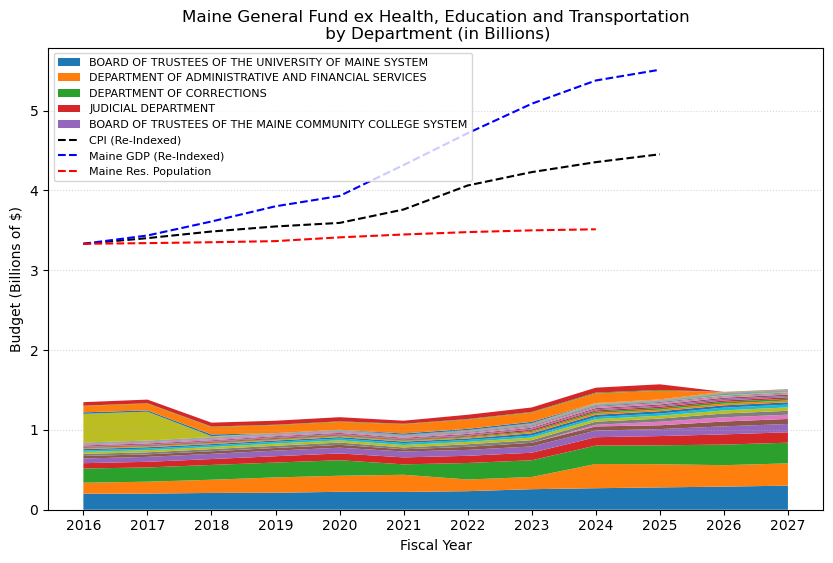

In [53]:
# Chart Everything ex main departments

fig, ax = plt.subplots(figsize=(10,6))

ex_big_df = me_as_reported_df.reset_index()
ex_big_df = ex_big_df[(ex_big_df['Department'] != 'DEPARTMENT OF HEALTH AND HUMAN SERVICES (Formerly DHS)') & (ex_big_df['Department'] != 'DEPARTMENT OF EDUCATION') & (ex_big_df['Department'] != 'DEPARTMENT OF TRANSPORTATION')]
ex_big_df.set_index(['Department', 'Funding Source'], inplace=True)

produce_funding_chart(ax, 'GENERAL FUND', ex_big_df, 'General Fund ex Health, Education and Transportation\n')

fig.show()

In [54]:
ex_big_df.head()

2016  \
Department                                         Funding Source                           
DEPARTMENT OF ADMINISTRATIVE AND FINANCIAL SERV... GENERAL FUND               137624268.0   
                                                   HIGHWAY FUND                 2390766.0   
                                                   FEDERAL EXPENDITURES FUND     490810.0   
                                                   FUND FOR A HEALTHY MAINE           NaN   
                                                   OTHER SPECIAL REVENUE       32052674.0   

                                                                                     2017  \
Department                                         Funding Source                           
DEPARTMENT OF ADMINISTRATIVE AND FINANCIAL SERV... GENERAL FUND               149382890.0   
                                                   HIGHWAY FUND                 2378074.0   
                                                   FEDERAL EXPENDITURES FUND     494350.0   
                                                   FUND FOR A HEALTHY MAINE           NaN   
                                                   OTHER SPECIAL REVENUE       32776674.0   

                                                                                     2018  \
Department                                         Funding Source                           
DEPARTMENT OF ADMINISTRATIVE AND FINANCIAL SERV... GENERAL FUND               165053864.0   
                                                   HIGHWAY FUND                 2532375.0   
                                                   FEDERAL EXPENDITURES FUND     494350.0   
                                                   FUND FOR A HEALTHY MAINE           NaN   
                                                   OTHER SPECIAL REVENUE       37098962.0   

                                                                                     2019  \
Department                                         Funding Source                           
DEPARTMENT OF ADMINISTRATIVE AND FINANCIAL SERV... GENERAL FUND               192231187.0   
                                                   HIGHWAY FUND                 2548988.0   
                                                   FEDERAL EXPENDITURES FUND     494350.0   
                                                   FUND FOR A HEALTHY MAINE           NaN   
                                                   OTHER SPECIAL REVENUE       38818129.0   

                                                                                     2020  \
Department                                         Funding Source                           
DEPARTMENT OF ADMINISTRATIVE AND FINANCIAL SERV... GENERAL FUND               201062755.0   
                                                   HIGHWAY FUND                 2552609.0   
                                                   FEDERAL EXPENDITURES FUND     494350.0   
                                                   FUND FOR A HEALTHY MAINE           NaN   
                                                   OTHER SPECIAL REVENUE       38691348.0   

                                                                                     2021  \
Department                                         Funding Source                           
DEPARTMENT OF ADMINISTRATIVE AND FINANCIAL SERV... GENERAL FUND               215306110.0   
                                                   HIGHWAY FUND                 2517328.0   
                                                   FEDERAL EXPENDITURES FUND     494350.0   
                                                   FUND FOR A HEALTHY MAINE           NaN   
                                                   OTHER SPECIAL REVENUE       38703956.0   

                                                                                     2022  \
Department                                         Funding Source               

In [55]:
ex_big_total_df = ex_big_df.xs('DEPARTMENT TOTAL', level='Funding Source')

mean_small = ex_big_total_df.mean() / 1e6
count_small = (ex_big_total_df > 0).sum()


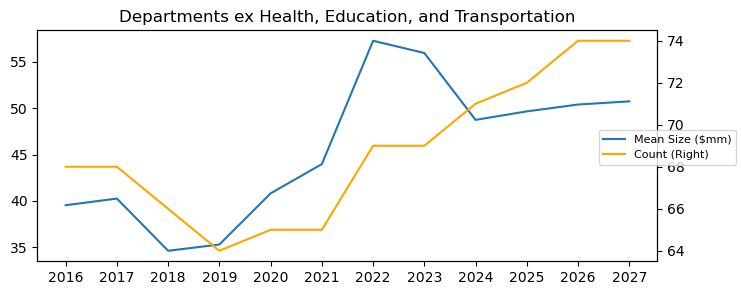

In [56]:
fig, ax = plt.subplots(figsize=(8,3))

ax2 = ax.twinx()

ax.plot(mean_small, label='Mean Size ($mm)')
ax2.plot(count_small, color='orange', label='Count (Right)')

ax.set_title('Departments ex Health, Education, and Transportation')

fig.legend(loc='right', fontsize=8)